# Chapter 3: Classification

## 📚 Assignment Summary

This notebook serves as the submission for **Chapter 3** of the book *"Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow."*

**Chapter Objective:** This chapter introduces classification, one of the most common supervised learning tasks. We will use the MNIST dataset to explore key concepts:

* Training a binary classifier (e.g., 5 vs. not-5).
* Evaluating a classifier using various performance measures (accuracy, confusion matrix, precision, recall, F1-score, ROC curve).
* Understanding the precision/recall trade-off.
* Working with multiclass, multilabel, and multioutput classification.
* Performing error analysis to improve models.

This notebook reproduces all code from the chapter and provides theoretical explanations for each concept.

## 1. Setup

First, let's import the necessary modules and define helper functions for plotting.

In [1]:
# Common imports
import numpy as np
import os

# To make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Helper function to plot digits (from the book's GitHub repository)
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

## 2. MNIST Dataset

This chapter uses the MNIST dataset, which is a set of 70,000 small images of digits handwritten by high school students and US Census Bureau employees. It's often called the "hello world" of Machine Learning. Scikit-Learn provides a helper function to download it.

In [2]:
from sklearn.datasets import fetch_openml

# This may take a couple of minutes
mnist = fetch_openml('mnist_784', version=1)
print(mnist.keys())

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])


In [3]:
# Datasets loaded by Scikit-Learn have a similar dictionary structure
X, y = mnist["data"], mnist["target"]

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (70000, 784)
y shape: (70000,)


There are 70,000 images, and each image has 784 features. This is because each image is 28×28 pixels, and each feature simply represents one pixel’s intensity, from 0 (white) to 255 (black).

Let's plot one of the digits to see what it looks like.

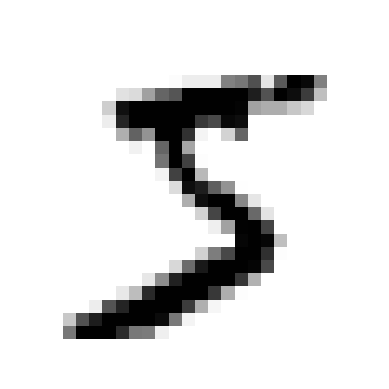

Label: 5


In [5]:
some_digit = X.values[0]
plot_digit(some_digit)
plt.show()

# The label for this digit is '5'
print("Label:", y[0])

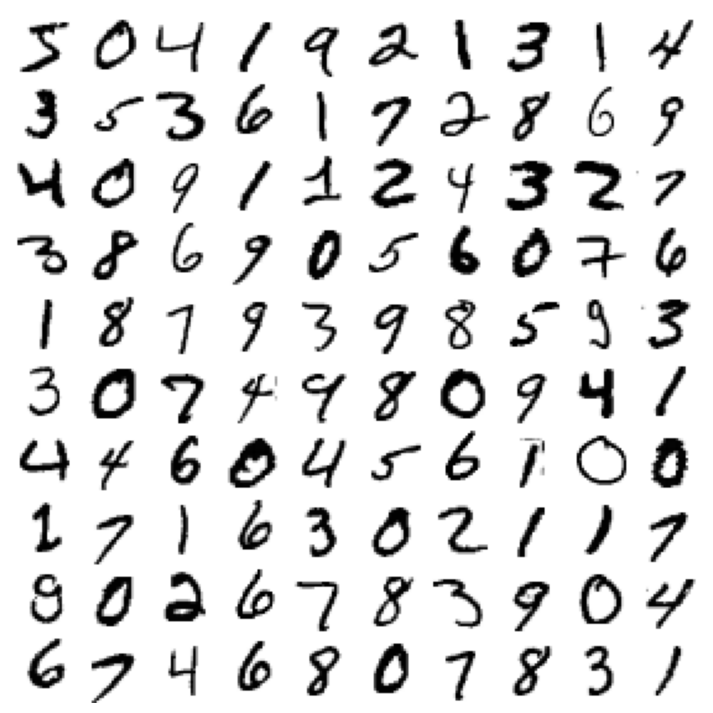

In [9]:
# The labels are strings, so let's cast them to integers
y = y.astype(np.uint8)

# Let's also plot a few more digits
plt.figure(figsize=(9,9))
example_images = X[:100].values # Convert to numpy array
plot_digits(example_images, images_per_row=10)
plt.show()

### Create a Test Set

The MNIST dataset is already split into a training set (the first 60,000 images) and a test set (the last 10,000 images). The training set is also already shuffled, which is good as it ensures all cross-validation folds will be similar.

In [10]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## 3. Training a Binary Classifier

Let's simplify the problem and try to identify just one digit: the number 5. This "5-detector" will be a **binary classifier**, capable of distinguishing between just two classes: 5 and not-5.

Let's create the target vectors for this classification task.

In [11]:
y_train_5 = (y_train == 5)  # True for all 5s, False for all other digits.
y_test_5 = (y_test == 5)

Now let's pick a classifier and train it. A good place to start is with a **Stochastic Gradient Descent (SGD)** classifier, using Scikit-Learn’s `SGDClassifier` class. This classifier is fast and capable of handling very large datasets efficiently.

In [12]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42) # Set random_state for reproducible results
sgd_clf.fit(X_train, y_train_5)

# Now, let's detect images of the number 5
print("Prediction for 'some_digit' (which is a 5):")
print(sgd_clf.predict([some_digit]))

Prediction for 'some_digit' (which is a 5):
[ True]


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


The classifier correctly guesses that the image is a 5. Now, let's evaluate its performance.

## 4. Performance Measures

Evaluating a classifier is often trickier than evaluating a regressor. We will explore several methods.

### 4.1. Measuring Accuracy Using Cross-Validation

We can use `cross_val_score` to evaluate our `SGDClassifier` model using K-fold cross-validation.

In [13]:
from sklearn.model_selection import cross_val_score

# This may take a few minutes
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

Wow! Over 95% accuracy on all folds? This looks amazing, but accuracy is generally *not* the preferred performance measure for classifiers, especially when you are dealing with **skewed datasets** (i.e., when some classes are much more frequent than others).

Let's see why. Let's create a classifier that just classifies every single image in the "not-5" class.

In [14]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

This dumb classifier has over 90% accuracy! This is simply because only about 10% of the images are 5s. If you always guess "not-5", you will be right about 90% of the time. This demonstrates why accuracy is a poor measure for skewed datasets.


### 4.2. Confusion Matrix

A much better way to evaluate a classifier is to look at the **confusion matrix**. The general idea is to count the number of times instances of class A are classified as class B.

To compute it, we first need a set of predictions to compare to the actual targets. We can use `cross_val_predict()` which, instead of returning scores, returns the predictions made on each test fold.

In [15]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [16]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

#### 🧑‍🏫 Theoretical Deep-Dive: Understanding the Confusion Matrix

Each row in a confusion matrix represents an **actual class**, while each column represents a **predicted class**.

The matrix for our 5-detector looks like this:

| | Predicted: Not-5 | Predicted: 5 |
|---|---|---|
| **Actual: Not-5** | 53,892 (True Negatives) | 687 (False Positives) |
| **Actual: 5** | 1,891 (False Negatives) | 3,530 (True Positives) |

* **True Negatives (TN):** Non-5s that were correctly classified as non-5s.
* **False Positives (FP):** Non-5s that were incorrectly classified as 5s.
* **False Negatives (FN):** 5s that were incorrectly classified as non-5s.
* **True Positives (TP):** 5s that were correctly classified as 5s.

### 4.3. Precision, Recall, and F1-Score

The confusion matrix gives us a lot of information, but sometimes we may prefer more concise metrics.

**Precision:** The accuracy of the *positive* predictions. "When the model predicts a 5, how often is it correct?"
$$ \text{Precision} = \frac{TP}{TP + FP} $$

**Recall (Sensitivity or True Positive Rate):** The ratio of positive instances that are correctly detected by the classifier. "What percentage of 5s did the model correctly identify?"
$$ \text{Recall} = \frac{TP}{TP + FN} $$


In [17]:
from sklearn.metrics import precision_score, recall_score

print("Precision:", precision_score(y_train_5, y_train_pred))
print("Recall:", recall_score(y_train_5, y_train_pred))

Precision: 0.8370879772350012
Recall: 0.6511713705958311


Our 5-detector doesn't look as shiny now. It is correct only 83.7% of the time it predicts a 5, and it only detects 65.1% of all 5s.

It is often convenient to combine precision and recall into a single metric called the **F1-score**. The F1-score is the **harmonic mean** of precision and recall. It gives more weight to low values, so a high F1-score is only possible if *both* precision and recall are high.

In [18]:
from sklearn.metrics import f1_score

print("F1 Score:", f1_score(y_train_5, y_train_pred))

F1 Score: 0.7325171197343847


### 4.4. Precision/Recall Trade-off

Unfortunately, you can’t have it both ways: increasing precision reduces recall, and vice versa. This is called the **precision/recall trade-off**.

The `SGDClassifier` makes its decisions based on a score from a **decision function**. If that score is greater than a **threshold**, it assigns the instance to the positive class. Raising this threshold increases precision (the model is pickier) but decreases recall (it misses more positive instances).

We can get the decision scores instead of predictions:

In [19]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

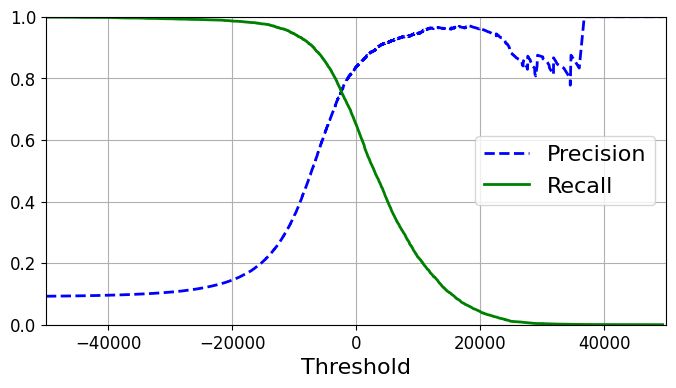

In [20]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16)
    plt.xlabel("Threshold", fontsize=16)
    plt.grid(True)
    plt.axis([-50000, 50000, 0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

Another way to select a good precision/recall trade-off is to plot precision directly against recall.

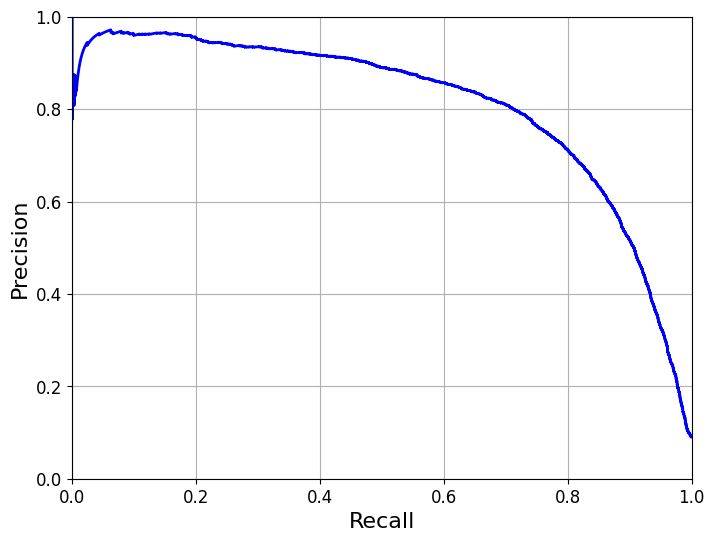

In [21]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.show()

Let's say we decide to aim for 90% precision. We can find the threshold that gives us this precision.

In [22]:
# Find the lowest threshold that gives at least 90% precision
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
print("Threshold for 90% precision:", threshold_90_precision)

# Now we can make predictions based on this threshold
y_train_pred_90 = (y_scores >= threshold_90_precision)

print("Precision at this threshold:", precision_score(y_train_5, y_train_pred_90))
print("Recall at this threshold:", recall_score(y_train_5, y_train_pred_90))

Threshold for 90% precision: 3370.0194991439557
Precision at this threshold: 0.9000345901072293
Recall at this threshold: 0.4799852425751706


### 4.5. The ROC Curve

The **Receiver Operating Characteristic (ROC)** curve is another common tool. It plots the **True Positive Rate (TPR)** (another name for recall) against the **False Positive Rate (FPR)**.

* **FPR** is the ratio of negative instances that are incorrectly classified as positive (`FP / (FP + TN)`).
* A perfect classifier will have a ROC curve that goes straight up to the top-left corner (TPR = 1, FPR = 0).

One way to compare classifiers is to measure the **Area Under the Curve (AUC)**. A perfect classifier will have a ROC AUC of 1, while a purely random classifier will have a ROC AUC of 0.5.

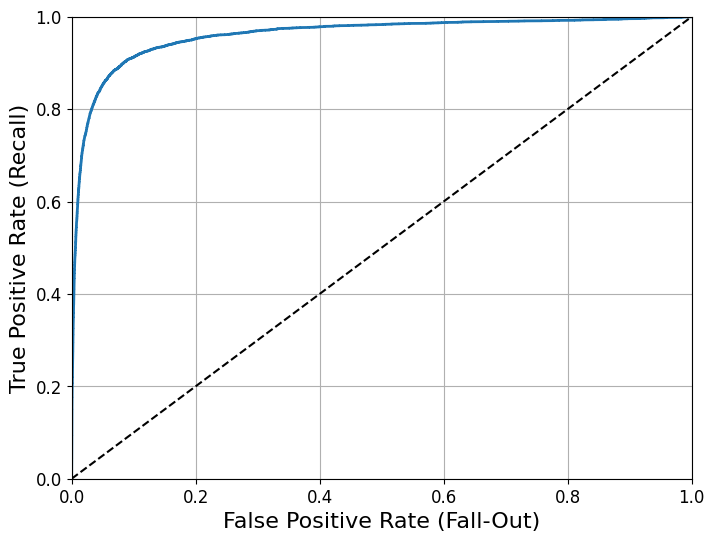

In [23]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # Dashed diagonal for random classifier
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16)
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()

In [24]:
from sklearn.metrics import roc_auc_score

print("ROC AUC Score:", roc_auc_score(y_train_5, y_scores))

ROC AUC Score: 0.9604938554008616


**Rule of thumb:** Use the **Precision/Recall (PR) curve** whenever the positive class is rare or when you care more about the false positives than the false negatives. Otherwise, use the **ROC curve**.

Let's train a `RandomForestClassifier` and compare its ROC curve to the `SGDClassifier`'s. A Random Forest has a `predict_proba()` method, which we can use to get scores.

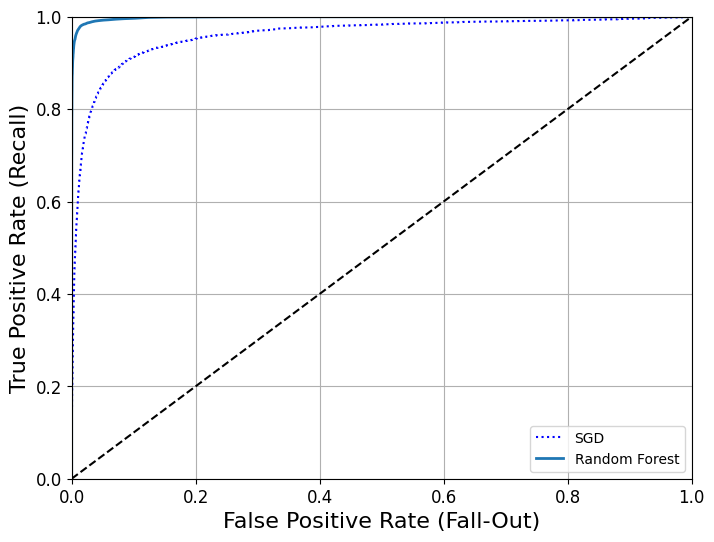

Random Forest ROC AUC Score: 0.9983436731328145


In [25]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

# The ROC curve needs scores, not probabilities. We use the positive class's probability as the score.
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

# Plot both ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

print("Random Forest ROC AUC Score:", roc_auc_score(y_train_5, y_scores_forest))

The Random Forest classifier is much better. Its ROC curve is closer to the top-left corner, and its ROC AUC score is significantly higher.

## 5. Multiclass Classification

**Multiclass classifiers** (or *multinomial classifiers*) can distinguish between more than two classes.

Some algorithms (like SGD, Random Forests, Naive Bayes) can handle multiple classes natively. Others (like SVM, Logistic Regression) are strictly binary classifiers. However, you can use binary classifiers for multiclass tasks using two main strategies:

* **One-versus-the-Rest (OvR) / One-versus-All (OvA):** Train 10 binary classifiers, one for each digit (a 0-detector, a 1-detector, etc.). When you want to classify an image, you get the decision score from each classifier and select the class whose classifier outputs the highest score.
* **One-versus-One (OvO):** Train a binary classifier for every pair of digits (a 0-vs-1, a 0-vs-2, a 1-vs-2, etc.). For N classes, this requires training N × (N – 1) / 2 classifiers. For MNIST, this means 45 classifiers. When you classify an image, you run it through all 45 classifiers and see which class wins the most duels.

Scikit-Learn detects when you try to use a binary classifier for a multiclass task, and it automatically runs OvR or OvO depending on the algorithm (e.g., SVMs use OvO, most others use OvR).

In [26]:
# Let's train an SVM. This uses OvO under the hood.
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train[:2000], y_train[:2000]) # Train on a small subset for speed

print("Prediction for 'some_digit':", svm_clf.predict([some_digit]))

# Get the scores for each of the 10 classes
some_digit_scores = svm_clf.decision_function([some_digit])
print("\nScores per class:", some_digit_scores)
print("Highest score index:", np.argmax(some_digit_scores))
print("Class:", svm_clf.classes_[5])

Prediction for 'some_digit': [5]

Scores per class: [[ 3.79297828  0.72949369  6.06184129  8.29800527 -0.29383983  9.30157597
   1.74723215  2.77365456  7.20601456  4.82245092]]
Highest score index: 5
Class: 5


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


In [27]:
# SGDClassifier can handle multiclass directly. Let's train it on all digits.
sgd_clf.fit(X_train, y_train) # y_train, not y_train_5
print("SGD prediction for 'some_digit':", sgd_clf.predict([some_digit]))

SGD prediction for 'some_digit': [3]


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


In [28]:
# Let's evaluate this multiclass SGD classifier
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

It gets over 84% on all folds. This is not bad, but we can improve it by simply scaling the inputs.

In [29]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

print("--- Evaluating SGD with scaled data ---")
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

--- Evaluating SGD with scaled data ---


array([0.8983, 0.891 , 0.9018])

## 6. Error Analysis

Now that we have a promising model, we can analyze the types of errors it makes. A good way to do this is to use the confusion matrix again.

In [30]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
print(conf_mx)

[[5577    0   22    5    8   43   36    6  225    1]
 [   0 6400   37   24    4   44    4    7  212   10]
 [  27   27 5220   92   73   27   67   36  378   11]
 [  22   17  117 5227    2  203   27   40  403   73]
 [  12   14   41    9 5182   12   34   27  347  164]
 [  27   15   30  168   53 4444   75   14  535   60]
 [  30   15   42    3   44   97 5552    3  131    1]
 [  21   10   51   30   49   12    3 5684  195  210]
 [  17   63   48   86    3  126   25   10 5429   44]
 [  25   18   30   64  118   36    1  179  371 5107]]


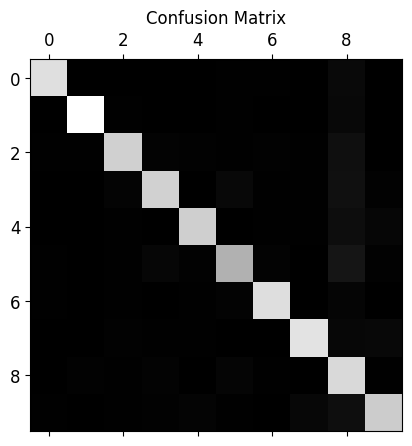

In [31]:
# This is often more convenient to view as an image
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.title("Confusion Matrix")
plt.show()

This matrix looks good, as most images are on the main diagonal (meaning they were classified correctly). The 5s look slightly darker, which could mean there are fewer images of 5s or that the classifier does not perform as well on 5s.

Let's focus the plot on the errors. We'll divide each value by the number of images in its actual class (to compare error *rates*) and fill the diagonal with zeros to see only the errors.

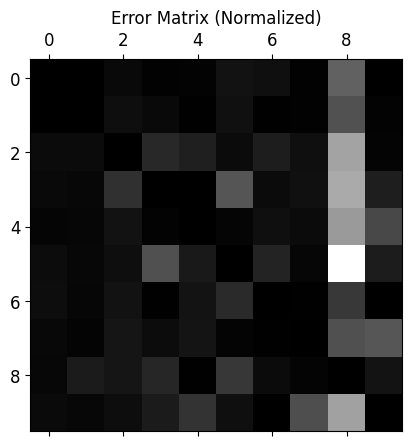

In [32]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.title("Error Matrix (Normalized)")
plt.show()

This matrix clearly shows the kinds of errors the classifier makes. Remember that rows are actual classes, while columns are predicted classes.

* The column for class 8 is bright, which means many digits get misclassified *as* 8s.
* The row for class 8 is not that bad, meaning most actual 8s get correctly classified.
* The 3s and 5s often get confused in both directions.

Analyzing this plot suggests we should focus on reducing the false 8s. We can also plot examples of the 3s and 5s that get confused.

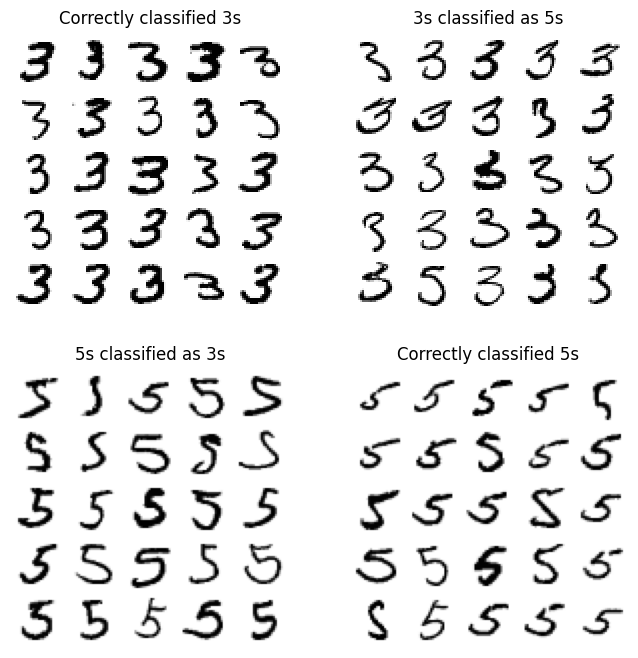

In [34]:
# Plotting examples of 3s and 5s
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25].values, images_per_row=5)
plt.title("Correctly classified 3s")
plt.subplot(222); plot_digits(X_ab[:25].values, images_per_row=5)
plt.title("3s classified as 5s")
plt.subplot(223); plot_digits(X_ba[:25].values, images_per_row=5)
plt.title("5s classified as 3s")
plt.subplot(224); plot_digits(X_bb[:25].values, images_per_row=5)
plt.title("Correctly classified 5s")
plt.show()

This analysis shows that the errors are often on ambiguous, poorly written digits. The `SGDClassifier` is a linear model, so it makes errors when the classes are not linearly separable. It is sensitive to image shifting and rotation. Preprocessing the images to ensure they are well-centered and not too rotated could help.

## 7. Multilabel Classification

Until now, each instance has been assigned to only one class. In **multilabel classification**, the system outputs multiple binary tags. For example, a face-recognition system might identify several people in one picture, outputting `[1, 0, 1]` for "Alice yes, Bob no, Charlie yes."

Let's create a multilabel target for our MNIST data: one label to identify large digits (7, 8, or 9) and one to identify odd digits.

In [35]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

print("Multilabel prediction for 'some_digit' (a 5):")
print(knn_clf.predict([some_digit]))

Multilabel prediction for 'some_digit' (a 5):


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


[[False  True]]


The classifier correctly predicts that the digit 5 is *not large* (False) and *is odd* (True).

There are many ways to evaluate a multilabel classifier. One option is to measure the F1 score for each individual label and then compute the average score.

In [36]:
# This cell may take a very long time to run

y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)

# 'average="macro"' computes the mean F1 score, assuming all labels are equally important
# 'average="weighted"' would give each label a weight equal to its support (number of instances)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.9764102655606048

## 8. Multioutput Classification

**Multioutput–multiclass classification** (or simply *multioutput classification*) is a generalization of multilabel classification where each label can be multiclass (i.e., it can have more than two possible values).

To illustrate this, let's build a system that removes noise from images. It will take a noisy digit image as input and will output a clean digit image. The classifier's output is multilabel (one label per pixel) and each label can have multiple values (pixel intensity from 0 to 255).

First, let's create the noisy dataset by adding noise to the pixel intensities.

In [37]:
# Add noise to the MNIST images
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise

# The target images are the original clean images
y_train_mod = X_train
y_test_mod = X_test

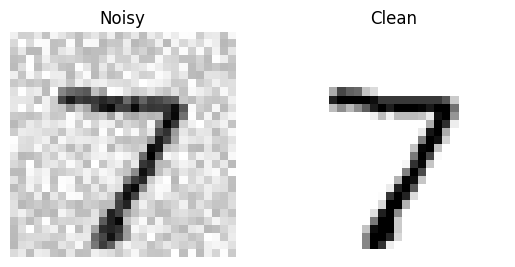

In [39]:
# Let's look at a noisy image and its clean target
some_index = 0
plt.subplot(121); plot_digit(X_test_mod.iloc[some_index].values)
plt.title("Noisy")
plt.subplot(122); plot_digit(y_test_mod.iloc[some_index].values)
plt.title("Clean")
plt.show()

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


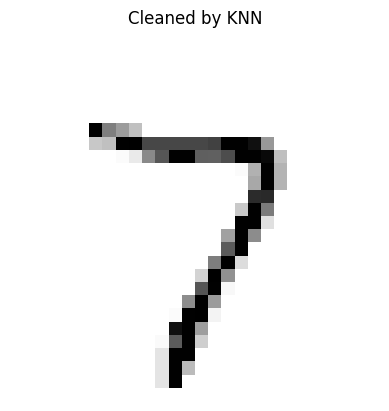

In [43]:
# Train a classifier to clean the image
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod.iloc[some_index].values])
plot_digit(clean_digit)
plt.title("Cleaned by KNN")
plt.show()

## Chapter 3 Conclusion

In this chapter, we covered a lot of ground in classification. We learned:

* The importance of choosing the right **performance metrics**, especially for skewed datasets, moving beyond simple accuracy.
* How to use the **confusion matrix**, **precision**, **recall**, **F1-score**, and **ROC curves** to get a much deeper understanding of our model's performance.
* The concept of the **precision/recall trade-off** and how to adjust the decision threshold to select the trade-off that best fits our task.
* How to build models for **multiclass**, **multilabel**, and **multioutput** tasks.
* The importance of **error analysis** in guiding our efforts to improve a model.

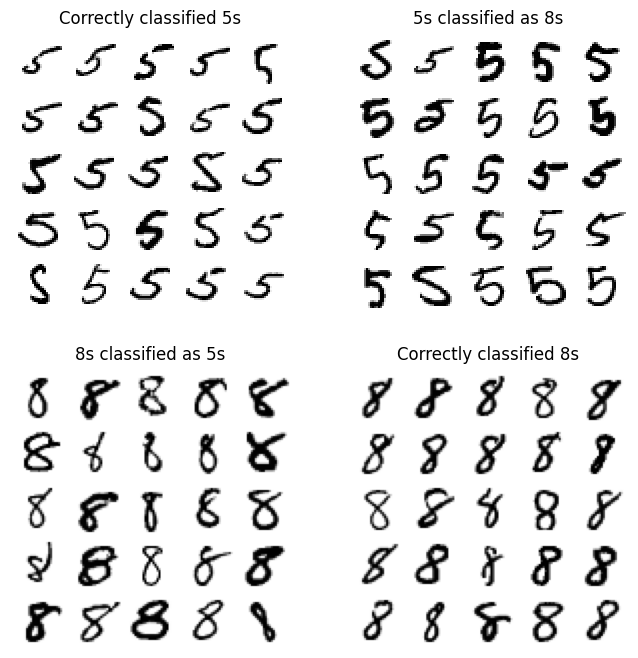

In [44]:
# Based on the error analysis from the confusion matrix, we observed that many digits get misclassified *as* 8s,
# and digits like 5s and 8s are sometimes confused. Let's visualize this specific confusion.

cl_a, cl_b = 5, 8 # We'll focus on confusion between digit 5 and digit 8

# Filter for actual digit 'cl_a' (5)
X_cl_a_cl_a = X_train[(y_train == cl_a) & (y_train_pred == cl_a)] # Correctly classified 'cl_a's
X_cl_a_cl_b = X_train[(y_train == cl_a) & (y_train_pred == cl_b)] # Actual 'cl_a's classified as 'cl_b's

# Filter for actual digit 'cl_b' (8)
X_cl_b_cl_a = X_train[(y_train == cl_b) & (y_train_pred == cl_a)] # Actual 'cl_b's classified as 'cl_a's
X_cl_b_cl_b = X_train[(y_train == cl_b) & (y_train_pred == cl_b)] # Correctly classified 'cl_b's

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_cl_a_cl_a[:25].values, images_per_row=5)
plt.title(f"Correctly classified {cl_a}s")
plt.subplot(222); plot_digits(X_cl_a_cl_b[:25].values, images_per_row=5)
plt.title(f"{cl_a}s classified as {cl_b}s")
plt.subplot(223); plot_digits(X_cl_b_cl_a[:25].values, images_per_row=5)
plt.title(f"{cl_b}s classified as {cl_a}s")
plt.subplot(224); plot_digits(X_cl_b_cl_b[:25].values, images_per_row=5)
plt.title(f"Correctly classified {cl_b}s")
plt.show()